In [1]:
import plotly.express as px
import plotly.graph_objects as go
import essentia
import essentia.standard as es
from essentia.standard import *
import numpy as np 
from midiutil.MidiFile import MIDIFile
import os
import matplotlib.pyplot as plt
from scipy.signal import medfilt

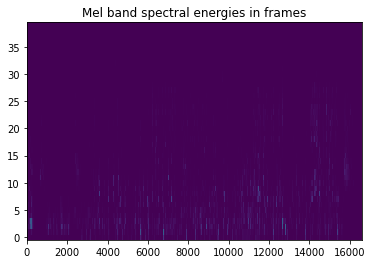

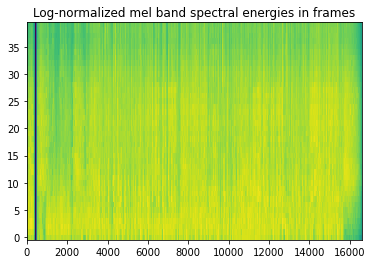

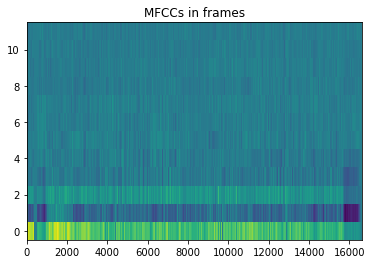

In [2]:
def segment(audio):

    # framecutter = frameCutter(frameSize=1024, hopSize=512)
    logNorm = UnaryOperator(type='log')

    wind = Windowing(type='hann')
    spec = Spectrum()
    mfcc = MFCC()
    pool = essentia.Pool()

    for frame in FrameGenerator(audio, frameSize=1024, hopSize=512, startFromZero=True):
        mfcc_bands, mfcc_coeffs = mfcc(spec(wind(frame)))
        pool.add('lowlevel.mfcc', mfcc_coeffs)
        pool.add('lowlevel.mfcc_bands', mfcc_bands)
        pool.add('lowlevel.mfcc_bands_log', logNorm(mfcc_bands))


    # fig = go.Figure(data=go.Heatmap(z=pool['lowlevel.mfcc_bands_log'].T))
    # fig.show()
    # # fig = px.imshow(pool['lowlevel.mfcc_bands'].T)
    # # fig.show()

    plt.imshow(pool['lowlevel.mfcc_bands'].T, aspect = 'auto', origin='lower', interpolation='none')
    plt.title("Mel band spectral energies in frames")
    plt.show()

    plt.imshow(pool['lowlevel.mfcc_bands_log'].T, aspect = 'auto', origin='lower', interpolation='none')
    plt.title("Log-normalized mel band spectral energies in frames")
    plt.show()

    
    plt.imshow(pool['lowlevel.mfcc'].T[1:,:], aspect='auto', origin='lower', interpolation='none')
    plt.title("MFCCs in frames")
    plt.show()

    # framecutter.signal = audio
    # framecutter.frame = wind.frame
    # spec.frame = framecutter.frame
    # mfcc.spectrum = spec.spectrum
    # pool.add('lowlevel.mfcc', mfcc.mfcc)

    # audio >> frameCutter.signal
    # frameCutter.frame >> wind.frame >> spec.frame
    # spec.spectrum >> mfcc.spectrum
    # mfcc.mfcc >> (pool, 'lowlevel.mfcc')

sr = 44100

audio = es.EqloudLoader(filename="data/2020/Iceland_Think About Things_Daði & Gagnamagnið.mp3", sampleRate=44100)()

segment(audio)

In [17]:
class Preprocessor():
    def __init__(self):
        #initiate algorithms
        self.pitch_extractor = es.PredominantPitchMelodia(frameSize=1024, hopSize=128, guessUnvoiced=True)
        self.rythm_extractor = es.RhythmExtractor2013()

        self.wind = Windowing(type='hann')
        self.spec = Spectrum()
        self.mfcc = MFCC()
        self.sbic = SBic(minLength=3)

    def save_midi(self, output_fn, notes, tempo):

        track = 0
        time = 0
        midifile = MIDIFile(1)

        midifile.addTrackName(track, time, "MIDI TRACK")
        midifile.addTempo(track, time, tempo)

        channel = 0
        volume = 100

        for note in notes:
            onset = note[0] * (tempo/60.)
            duration = note[1] * (tempo/60.)
            # duration = 1
            pitch = int(note[2])
            # print(pitch)
            midifile.addNote(track, channel, pitch, onset, duration, volume)

        with open(output_fn, "wb") as f:
            midifile.writeFile(f)

    def midi_to_notes(self, midi, fs, hop, smooth, minduration):

        # smooth midi pitch sequence first
        if (smooth > 0):
            filter_duration = smooth  # in seconds
            filter_size = int(filter_duration * fs / float(hop))
            if filter_size % 2 == 0:
                filter_size += 1
            midi_filt = medfilt(midi, filter_size)
        else:
            midi_filt = midi
        # print(len(midi),len(midi_filt))

        notes = []
        p_prev = 0
        duration = 0
        onset = 0
        for n, p in enumerate(midi_filt):
            if p == p_prev:
                duration += 1
            else:
                # treat 0 as silence
                if p_prev > 0:
                    # add note
                    duration_sec = duration * hop / float(fs)
                    # only add notes that are long enough
                    if duration_sec >= minduration:
                        onset_sec = onset * hop / float(fs)
                        notes.append((onset_sec, duration_sec, p_prev))

                # start new note
                onset = n
                duration = 1
                p_prev = p

        # add last note
        if p_prev > 0:
            # add note
            duration_sec = duration * hop / float(fs)
            onset_sec = onset * hop / float(fs)
            notes.append((onset_sec, duration_sec, p_prev))

        return notes


    def hz2midi(self, hz):

        # convert from Hz to midi note
        hz_nonneg = hz.copy()
        idx = hz_nonneg <= 0
        hz_nonneg[idx] = 1
        midi = 69 + 12*np.log2(hz_nonneg/440.)
        midi[idx] = 0

        # round
        midi = np.round(midi)

        return midi

    def segment(self, audio):
        # wind = Windowing(type='hann')
        # spec = Spectrum()
        # mfcc = MFCC()
        pool = essentia.Pool()

        for frame in FrameGenerator(audio, frameSize=1024, hopSize=512, startFromZero=True):
            _, mfcc_coeffs = self.mfcc(self.spec(self.wind(frame)))
            pool.add('lowlevel.mfcc', mfcc_coeffs)

        segments = self.sbic(pool['lowlevel.mfcc'].T)

        return 0 if len(segments) == 2 else int(segments[1])


    def audio_to_midi(self, input_fn, output_fn, smooth=0.25, minduration=0.1):
        fs = 44100
        hop = 128

        audio = es.EqloudLoader(filename=input_fn, sampleRate=fs)()
        start = self.segment(audio)
        audio = audio[start:]
        pitch_values = self.pitch_extractor(audio)
        # plt.plot(pitch_values)
        # plt.show()

        bpm = self.rythm_extractor(audio)[0]

        pitch_values = np.insert(pitch_values, 0, values=[0]*8)

        midi_pitch = self.hz2midi(pitch_values)
        notes = self.midi_to_notes(midi_pitch, fs, hop, smooth, minduration)

        self.save_midi(output_fn, notes, bpm)

In [18]:
proc = Preprocessor()
filename = "/home/lex/Documents/scriptie/data/2020/Iceland_Think About Things_Daði & Gagnamagnið.mp3"
output = "test.mid"

proc.audio_to_midi(filename, output)




299


In [ ]:
proc = Preprocessor()
filename = "data/2020/Iceland_Think About Things_Daði & Gagnamagnið.mp3"
output = "midi_output/Iceland_Think About Things_Daði & Gagnamagnið.mid"

proc.audio_to_midi(filename, output)